In [1]:
# pip install wfdb

In [2]:
# pip install py-ecg-detectors 

In [3]:
# pip install imblearn

### Model Evaluation

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from scipy.signal import cheby2, filtfilt, iirnotch

import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from ecgdetectors import Detectors
import numpy as np
import pickle
import torch.nn as nn


### Recorded Data Pre-processing

In [2]:


def cheby2_bandpass_filter(data, lowcut, highcut, fs, order=5, rs=30):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs, [low, high], btype='band')
    y = filtfilt(b, a, data)
    #y = data
    return y


def notch_filter(data, notch_freq, q, fs):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, q)
    y = filtfilt(b, a, data)
    return y

import scipy.signal as signal

def process_ecg_data(ecg_signal, fs, target_fs):
    if fs != target_fs:
        ecg_signal = signal.resample(ecg_signal, int(ecg_signal.size * target_fs / fs))
    filtered_ecg_signal = cheby2_bandpass_filter(ecg_signal, 5, 50, target_fs, order=6, rs=30)
    filtered_ecg_signal = notch_filter(filtered_ecg_signal, 50, 30, target_fs)
    return filtered_ecg_signal


def extract_beats(ecg_data, fs, target_fs, window_size=280):
    processed_ecg_data = process_ecg_data(ecg_data, fs, target_fs)
    detectors = Detectors(target_fs)
    r_peaks = detectors.wqrs_detector(processed_ecg_data)

    beat_locations = []

    half_window = window_size // 2
    for i, r_peak in enumerate(r_peaks):
        if r_peak - half_window >= 0 and r_peak + half_window < len(processed_ecg_data):
            beat_location = processed_ecg_data[r_peak - half_window:r_peak + half_window]
            beat_locations.append(beat_location)

    return np.array(beat_locations)

fs = 512
target_fs = 360
window_size = 280

# Read the CSV file
#df = pd.read_csv("3leadnoMC.csv")
#df = pd.read_csv("3leadwMC.csv")
#df = pd.read_csv("posnegnoMC.csv")
df = pd.read_csv("3leadnoMC.csv")
#df = pd.read_csv("data1.csv")
#Extract the ECG data from the first column
ecg_data = df.iloc[:, 0].values

# Process the ECG data
processed_ecg_data = process_ecg_data(ecg_data, fs, target_fs)

# Extract beats and annotations
beats = extract_beats(processed_ecg_data, fs, target_fs, window_size)

# Load the saved StandardScaler object from the file
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load the saved label_encoder object from the file
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)
   
    
    
# Scale and reshape the beats
scaled_beats = scaler.transform(beats)
X = torch.tensor(scaled_beats, dtype=torch.float32).unsqueeze(1)

# Predict the classes
# Load the model

class EcgModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EcgModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    
input_size = 280
hidden_size = 64
num_layers = 2
num_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EcgModel(input_size, hidden_size, num_layers, num_classes).to(device)

model.load_state_dict(torch.load("finale_model.pt"))
model.to(device)
model.eval()




c:\Users\zhehao\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\zhehao\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


EcgModel(
  (lstm): LSTM(280, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

    Beat Class
0      1     Q
1      2     V
2      3     V
3      4     F
4      5     F
5      6     F
6      7     F
7      8     Q
8      9     F
9     10     F
10    11     F
11    12     F
12    13     V
13    14     F
14    15     Q
15    16     N
16    17     F
17    18     V
18    19     F
19    20     F
20    21     Q
21    22     N
22    23     F
23    24     N
24    25     Q
25    26     N
26    27     V
27    28     N
28    29     Q
29    30     Q
30    31     V
31    32     Q
32    33     V
0
1


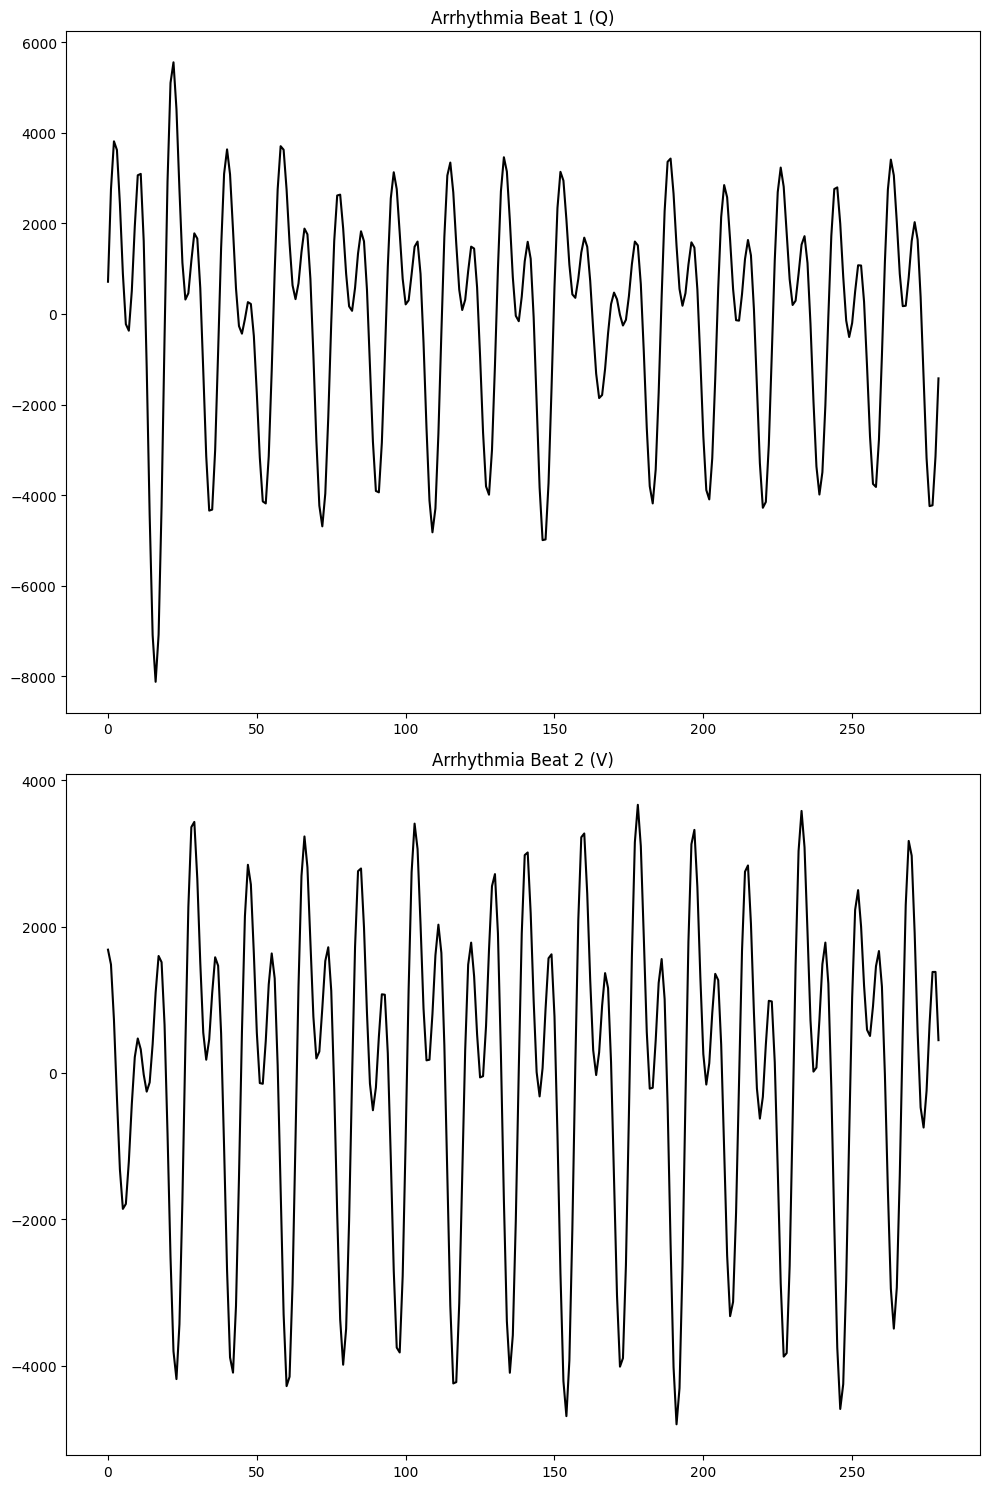

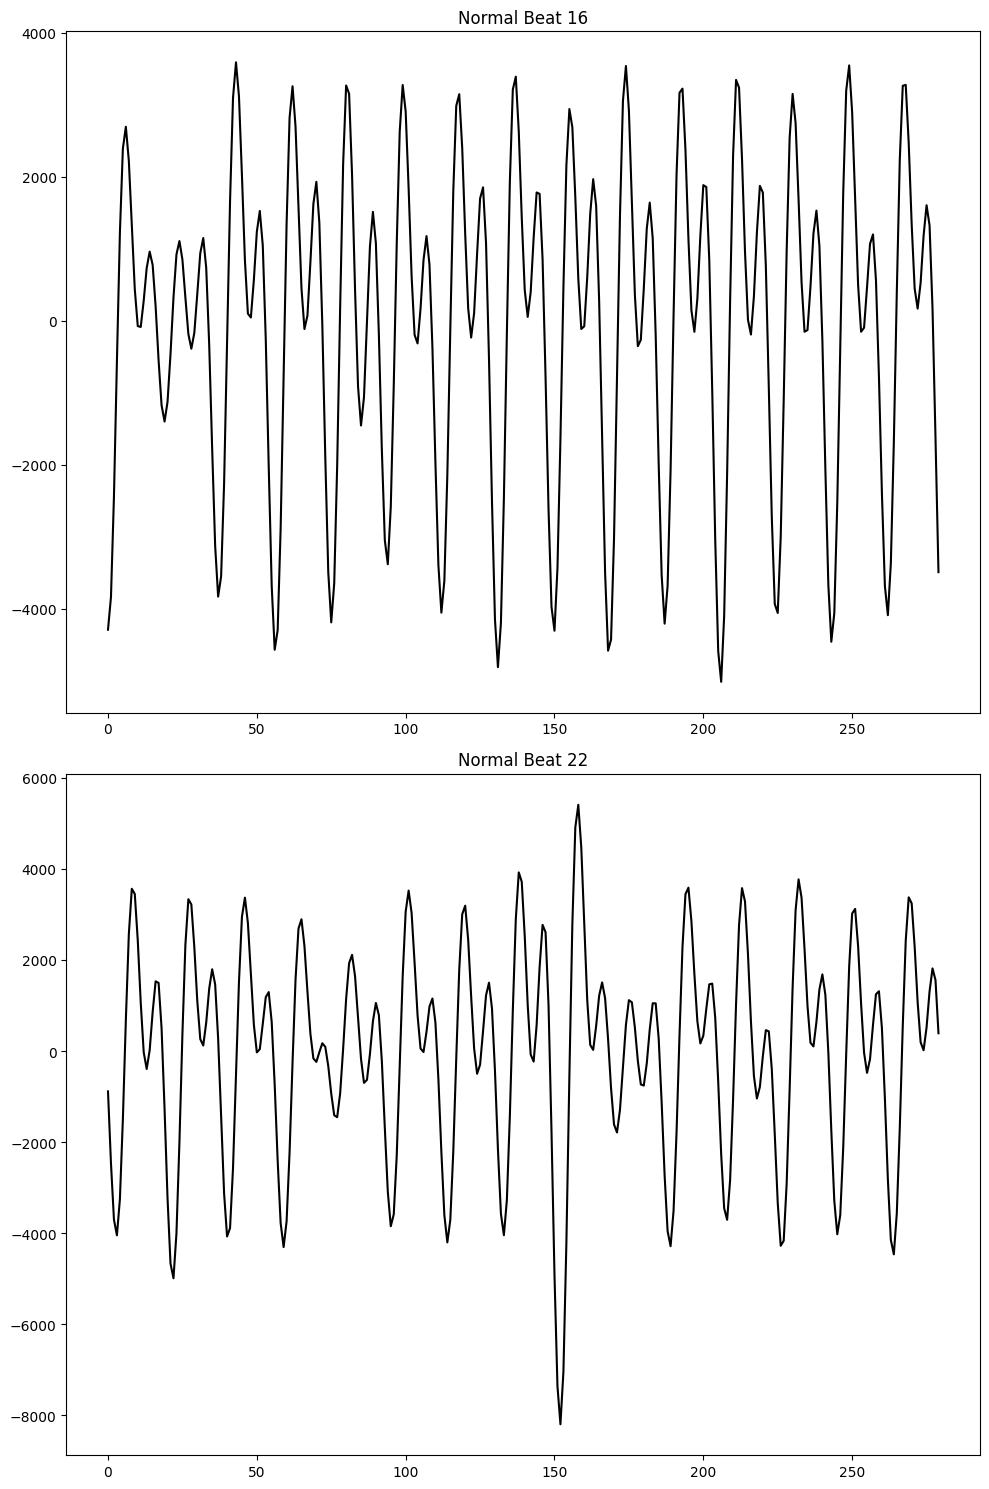

In [4]:
import glob
recorded_data=glob.glob("*.csv")


df = pd.read_csv("data8.csv")


#df = pd.read_csv("data1.csv")
#Extract the ECG data from the first column
ecg_data = df.iloc[:, 1].values

# Process the ECG data
processed_ecg_data = process_ecg_data(ecg_data, fs, target_fs)

# Extract beats and annotations
beats = extract_beats(processed_ecg_data, fs, target_fs, window_size)



# Scale and reshape the beats
scaled_beats = scaler.transform(beats)
X = torch.tensor(scaled_beats, dtype=torch.float32).unsqueeze(1)



with torch.no_grad():
    outputs = model(X.to(device))
    _, preds = torch.max(outputs, 1)
    classes = label_encoder.inverse_transform(preds.cpu().numpy())


# Create a DataFrame with the results
results_df = pd.DataFrame({"Beat": range(1, len(classes) + 1), "Class": classes})

print(results_df)



# Filter only the arrhythmia heartbeats (assuming non-arrhythmia heartbeats are labeled as 'N')
arrhythmia_df = results_df[results_df["Class"] != "N"]
num_arrhythmia_to_display = 2

# Filter only normal heartbeats
normal_df = results_df[results_df["Class"] == "N"]
num_normal_to_display = 2

# Plot the limited number of arrhythmia heartbeats
if not arrhythmia_df.empty:
    limited_arrhythmia_df = arrhythmia_df.head(num_arrhythmia_to_display)

    fig, axs = plt.subplots(nrows=num_arrhythmia_to_display, ncols=1, figsize=(10, 15))
    for i, ax in enumerate(axs):
        print(i)
        beat_index = limited_arrhythmia_df.iloc[i]["Beat"] - 1
        beat_class = limited_arrhythmia_df.iloc[i]["Class"]
        ax.plot(beats[beat_index], color="black")
        ax.set_title(f"Arrhythmia Beat {beat_index + 1} ({beat_class})")
    plt.tight_layout()
    plt.show()
else:
    print("No arrhythmia heartbeats found.")

# Plot the limited number of normal heartbeats if there are any
if not normal_df.empty:
    limited_normal_df = normal_df.head(num_normal_to_display)

    fig, axs = plt.subplots(nrows=num_normal_to_display, ncols=1, figsize=(10, 15))
    for i, ax in enumerate(axs):
        beat_index = limited_normal_df.iloc[i]["Beat"] - 1
        ax.plot(beats[beat_index], color="black")
        ax.set_title(f"Normal Beat {beat_index + 1}")
    plt.tight_layout()
    plt.show()
else:
    print("No normal heartbeats found.")